In [2]:
# Dataset taken from: https://archive.ics.uci.edu/dataset/162/forest+fires
# Author: P. Cortez
# Acessed: 11/12/2024
# License: Open Source
# Change log:
#   - dropped month and day
#   - Moved entire dataset to numpy array
#   - Made Target values binary
"""MLP Model built for predicting a forest fire on a given day"""

'MLP Model built for predicting a forest fire on a given day'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from tensorflow.keras.regularizers import l2

In [4]:
from ucimlrepo import fetch_ucirepo 
forest_fires = fetch_ucirepo(id=162) 
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns  
# data (as pandas dataframes) 
X = forest_fires.data.features 
y = forest_fires.data.targets 
X.drop(['month'], axis=1, inplace=True)
X.drop(['day'], axis=1, inplace=True)  
y = y.to_numpy()
X = X.to_numpy()
y_classifier = np.where(y > 0.0, 1, 0)
y_classifier = y_classifier.flatten()

C:\Users\willm\AppData\Local\Temp\ipykernel_10364\2291175216.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['month'], axis=1, inplace=True)
C:\Users\willm\AppData\Local\Temp\ipykernel_10364\2291175216.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['day'], axis=1, inplace=True)


In [5]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold 1 accuracy: 0.5769230769230769
Fold 1 F1-score: 0.5772991452991453
Fold 1 Recall: 0.5769230769230769
Fold 1 Precision: 0.5782888986013985


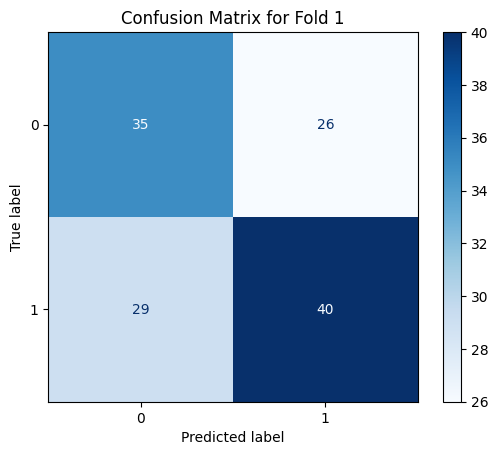

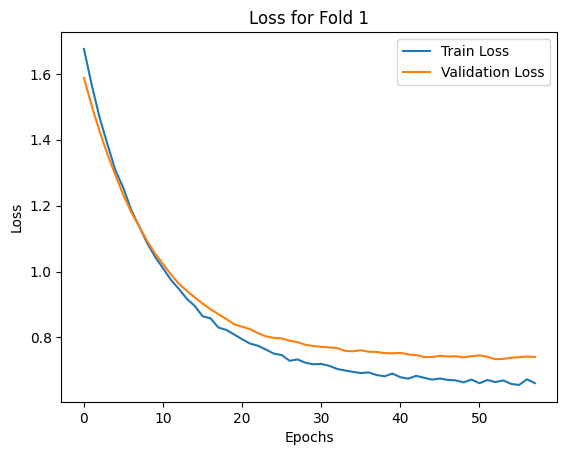

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold 2 accuracy: 0.6356589147286822
Fold 2 F1-score: 0.6252407937040273
Fold 2 Recall: 0.6356589147286822
Fold 2 Precision: 0.6508022354425815


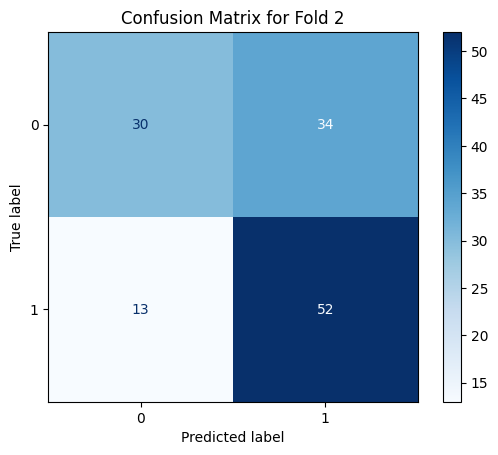

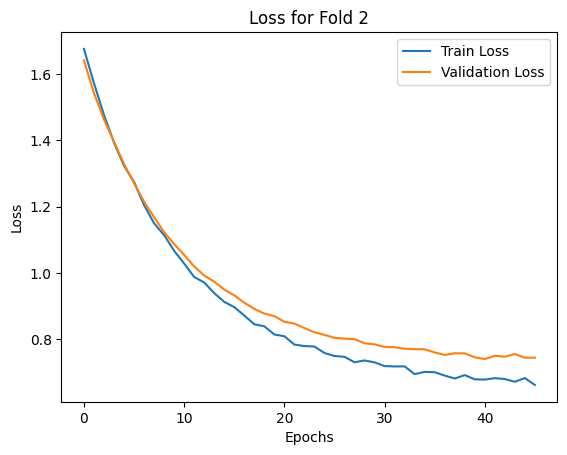

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F535DFF7E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 3 accuracy: 0.5581395348837209
Fold 3 F1-score: 0.5510658497085327
Fold 3 Recall: 0.5581395348837209
Fold 3 Precision: 0.5554957412192554


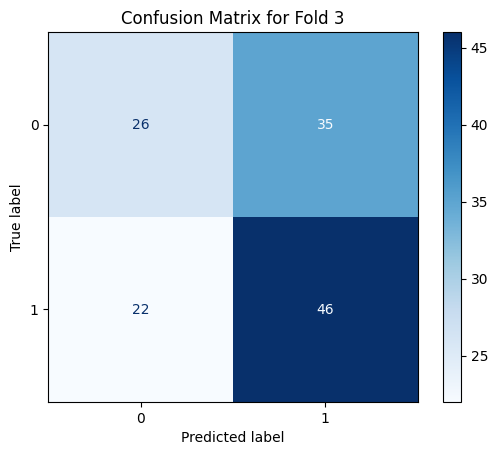

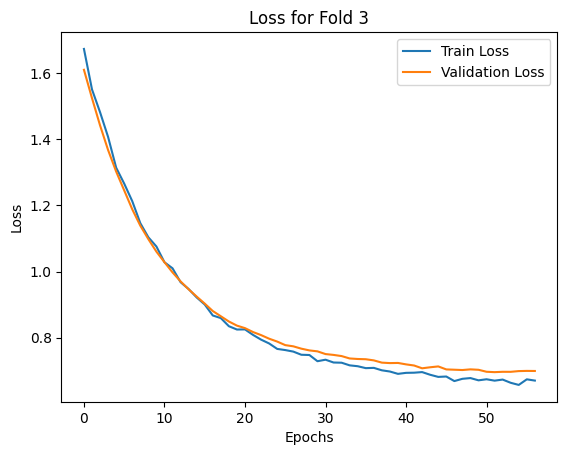

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold 4 accuracy: 0.5426356589147286
Fold 4 F1-score: 0.5386161004700366
Fold 4 Recall: 0.5426356589147286
Fold 4 Precision: 0.539900022458162


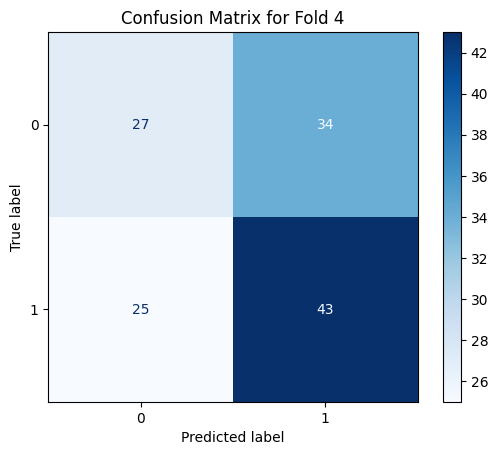

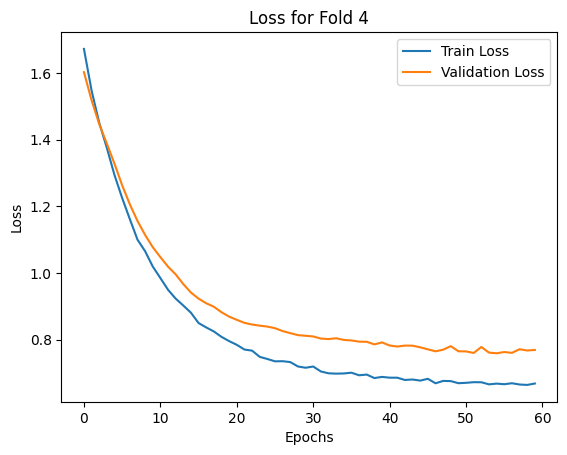

Mean accuracy across folds: 0.5783
Mean F-1 across folds: 0.5731
Mean Recall across folds: 0.5783
Mean Precision across folds: 0.5811


In [6]:
# Lists to store metrics
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
conf_matrices = []
conf_matrices = []
fold = 1

# Loop over each fold
for train_index, test_index in kf.split(X):
    # define input data for the fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_classifier[train_index], y_classifier[test_index]

    # Split training data for validation
    X_train_small, X_val, y_train_small, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=21)

    # Standardize the features
    scaler = StandardScaler()
    X_train_small_scaled = scaler.fit_transform(X_train_small)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA
    pca = PCA(n_components=0.95)  # Retain 95% variance
    X_train_pca = pca.fit_transform(X_train_small_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Build a simple neural network model
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),  # Dropout with a 30% rate
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    #define callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model and capture the history
    history = model.fit(X_train_pca, y_train_small, validation_data=(X_val_pca, y_val), epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)

    # Evaluate the model on the test fold
    y_pred = (model.predict(X_test_pca) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    # print scores
    accuracy_scores.append(accuracy)
    print(f"Fold {fold} accuracy: {accuracy}")
    print(f"Fold {fold} F1-score: {f1}")
    print(f"Fold {fold} Recall: {recall}")
    print(f"Fold {fold} Precision: {precision}")

    # append scores for mean
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.show()

    # Plot Training and Validation Loss for this fold
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss for Fold {fold}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    fold += 1

# Print overall accuracy
print(f"Mean accuracy across folds: {np.mean(accuracy_scores):.4f}")
print(f"Mean F-1 across folds: {np.mean(f1_scores):.4f}")
print(f"Mean Recall across folds: {np.mean(recall_scores):.4f}")
print(f"Mean Precision across folds: {np.mean(precision_scores):.4f}")

In [13]:
'''
   X  Y  FFMC    DMC     DC   ISI  temp   RH  wind  rain
   7  5  86.2   26.2   94.3   5.1   8.2   51   6.7   0.0  = 1
   2  4  81.6   56.7  665.6   1.9  21.9   71   5.8   0.0  = 0
'''

user_input = input("Please enter the required data separated by spaces: ")

numbers = list(list(map(float, user_input.split())))
real_data_array = np.array(numbers)
real_data_array = real_data_array.reshape(1, -1)

real_data_scaled = scaler.transform(real_data_array)
real_data_pca = pca.transform(real_data_scaled)

y_pred_1 = model.predict(real_data_pca)

for i in y_pred_1:
   if i[0] < 0.5:
      print("No fire today....", i[0]*100, "% chance of fire")
   else:
      print("Wild fire today!!!! RUN. ", i[0]*100, "% chance of fire. Find Bucket o' water!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
No fire today.... 45.471855998039246 % chance of fire
